### **Step 1:** Importing libraries

In [10]:
#importing libraries
import os 
# import cv
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.metrics import mean_squared_error as mse

from sklearn.neighbors import KNeighborsClassifier
from scipy.signal import convolve2d

import cv2 as cv
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

### **Step 2:** Loading images

In [11]:
def input_images(path):
    A = []
    A_flat = []
    size = 100

    # Iterate through images
    for img in os.listdir(path):
        try:
            # Read and grayscale image
            img_array = cv.imread(os.path.join(path, img), cv.IMREAD_GRAYSCALE)
            
            # Check if image reading was successful
            if img_array is None:
                print(f"Failed to read image: {img}")
                continue

            # Form matrix of an image
            img_pil = Image.fromarray(img_array)

            # Resize image
            img_100x100 = np.array(img_pil.resize((size, size)))

            A.append(img_100x100)

            # Flatten the image
            img_array_flat = img_100x100.flatten()

            A_flat.append(img_array_flat)
        except Exception as e:
            print(f"Exception occurred while processing image: {img} - {e}")

    if len(A) == 0 or len(A_flat) == 0:
        print("No valid images found in the directory.")
        return None, None

    # Convert to numpy array
    A_flat = np.asarray(A_flat)

    # Images as columns
    A_flat = A_flat.T

    return A, A_flat

# Test the modified function
A_images, A_flat_images = input_images("../brain_aneurysm_dataset/yes")
print(A_images)
print(A_flat_images)

Failed to read image: .DS_Store
[array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8), array([[196,  11,   0, ...,   1,   0,  82],
       [196,  11,   0, ...,   1,   0,  82],
       [196,  11,   0, ...,   1,   0,  82],
       ...,
       [196,  11,   0, ...,   1,   0,  82],
       [196,  11,   0, ...,   1,   0,  82],
       [196,  11,   0, ...,   1,   0,  82]], dtype=uint8), array([[13, 13, 13, ..., 13, 13, 13],
       [13, 13, 13, ..., 13, 13, 13],
       [13, 13, 13, ..., 13, 13, 13],
       ...,
       [13, 13, 13, ..., 13, 13, 13],
       [13, 13, 13, ..., 13, 13, 13],
       [13, 13, 13, ..., 13, 13, 13]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]

In [12]:
path_class_yes = "../brain_aneurysm_dataset/yes"
path_class_no = "../brain_aneurysm_dataset/no"

### **Step 3:** Applying Median filter with built-in function

In [13]:
def filter_median(img, kernel_size=3):
  img_median = cv.medianBlur(img, 3)
  return img_median

### **Step 4:** Applying Sobel edge detection with built-in function

In [14]:
def detector_sobel_x_y(img):
  sobel_x_y = cv.Sobel(src=img, ddepth=cv.CV_64F, dx=1, dy=1, ksize=5)
  return sobel_x_y

### **Step 5:** Normalizing the data for PCA

In [15]:
def normalization(A):

    # Column mean and standard deviation
    mu = np.mean(A, axis = 0)
    std = np.std(A, axis = 0)  
    
    # Substract the mean from A
    A_centered = A - mu   
    
    # Zero devizion
    std_filled = std.copy()
    std_filled[std == 0] = 1
    
    # Normalized A
    A_norm = A_centered / std_filled
    
    return A_norm, mu, std

### **Step 6:** Computing eigenvectors and eigenvalues of covariance matrix

In [16]:
def eigen(X):
  
    #Calculate the eigen values and eigen vectors
    EV, EVc = np.linalg.eigh(X)  

    #Order of eigenvalues (bigger to smaller)
    order = np.argsort(-EV)

    # Order the EV's
    EV = EV[order]

    # Construct matrix of eigenvectors
    EVc = EVc[:, order]
    
    return EV, EVc

### **Step 7:** PCA implementation

In [17]:

def PCA(X, num_components):

    # Calculate the data covariance matrix S -> S = 1 / (len(X) - 1) * np.matmul(X, X.T)
    S = np.cov(X)
    
    # Eigenvalues and corresponding eigenvectors for S
    eig_vals, eig_vecs = eigen(S)
    
    # Select eigen vectors
    U = eig_vecs[:, range(num_components)]
    
    # Find the projection_matrix which projects our input data onto the vector space spanned by the eigenvectors
    P = np.matmul(U, U.T)
    
    return P

### **Step 8:** Algorithm implementation

Failed to read image: .DS_Store
ROC AUC: %79.14285714285714


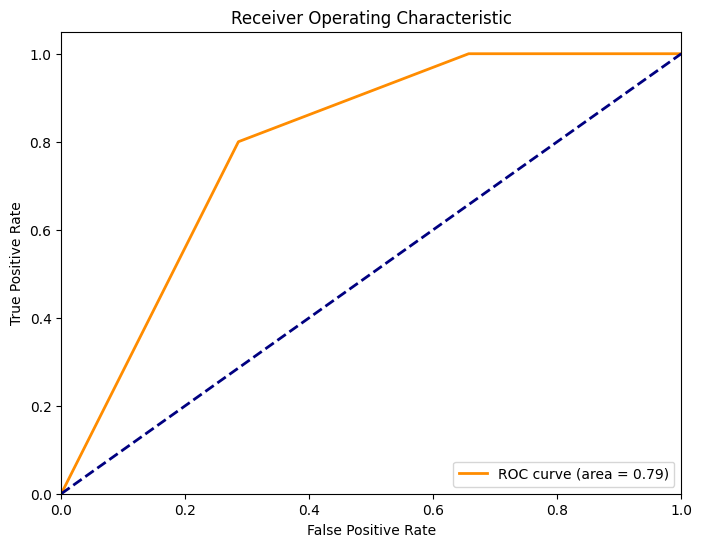

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

def pca_apply(X_t, X_f):

    loss = []
    reconstructions = []
    max_components = len(np.array(X_f).T)

    for num_component in range(1, max_components + 1):
        projection = PCA(X_t.T, num_component)
        y_transform = np.matmul(X_t, projection)
        error = mse(y_transform, X_f)
        reconstructions.append(y_transform)
        loss.append((num_component, error))

    #unstandardizing the reconstructed images
    reconstructions = np.asarray(reconstructions)
    loss = np.asarray(loss)

    yes_reconst = reconstructions[35, : , :]
    yes_reconst = yes_reconst
  
    return yes_reconst
  
def image_preprocessing(path_class_yes, path_class_no):

  A_flat, A_flat_yes = input_images(path_class_yes)
  X_no, A_flat_no = input_images(path_class_no)

  A_flat_yes = A_flat_yes.T
  A_flat_no = A_flat_no.T

  A_train_yes = A_flat_yes[:35].T
  A_test_yes = A_flat_yes[35:].T
  A_train_no = A_flat_no[:35].T
  A_test_no = A_flat_no[35:].T

  # Combine classes
  A_flat_yes_no_train = np.concatenate((A_train_yes.T, A_train_no.T)).T
  A_flat_yes_no_test = np.concatenate((A_test_yes.T, A_test_no.T)).T

  y_train = np.concatenate((np.ones(35), np.zeros(35)))
  y_test = np.concatenate((np.ones(70-35), np.zeros(70-35))) 
  
  
  # Apply filters
  gaussian_filter_applied = filter_median(A_flat_yes_no_train)
  gaussian_filter_applied_test = filter_median(A_flat_yes_no_test)

  # Apply edge detectors
  sobel_edge_detector_applies = detector_sobel_x_y(gaussian_filter_applied)
  sobel_edge_detector_applies_test = detector_sobel_x_y(gaussian_filter_applied_test)

  # PCA part
  X_train, mu_train, std_train = normalization(sobel_edge_detector_applies)
  X_test, mu_test, std_test = normalization(sobel_edge_detector_applies_test)


  processed_train = pca_apply(X_train, A_flat_yes_no_train)
  processed_test = pca_apply(X_test, A_flat_yes_no_test)
  clf = KNeighborsClassifier()
    
  clf.fit(processed_train.T,y_train)

  y_scores = clf.predict_proba(processed_test.T)[:,1]
  fpr, tpr, thresholds = roc_curve(y_test, y_scores)
  roc_auc = auc(fpr, tpr)  # Calculate area under the curve

    # Print the ROC AUC score
  print("ROC AUC: %{}".format(roc_auc * 100))

    # Plot ROC curve
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()  


  
  # clf = KNeighborsClassifier()
    
  # clf.fit(processed_train.T,y_train)

  # y_pred = clf.predict(processed_test.T)
  
  # print("Accuracy of KNN is %{}".format(accuracy_score(y_pred=y_pred,y_true=y_test)*100))
    
  # confmatrix = confusion_matrix(y_pred=y_pred,y_true=y_test)
    
  # plt.subplots(figsize=(6,6))
  # sns.heatmap(confmatrix,annot=True,fmt=".1f",linewidths=1.5)

image_preprocessing(path_class_yes, path_class_no)
